In [1]:
%pylab notebook
from datacube import Datacube
# from matplotlib import pyplot as plt
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
from datacube_stats.statistics import GeoMedian
cdc = Datacube(config='/g/data/u46/users/ext547/ewater/cambodia_cube/cambodia.conf')
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict

Populating the interactive namespace from numpy and matplotlib


Failed to resolve driver datacube.plugins.index::s3aio_index


In [4]:
cdc.list_measurements()

aliases  \
product                     measurement                                              
ls5_usgs_sr_scene           blue                                [band_1, sr_band1]   
                            green                               [band_2, sr_band2]   
                            red                                 [band_3, sr_band3]   
                            nir                                 [band_4, sr_band4]   
                            swir1                               [band_5, sr_band5]   
                            swir2                               [band_7, sr_band7]   
                            pixel_qa                                    [pixel_qa]   
ls7_usgs_sr_scene           blue                                [band_1, sr_band1]   
                            green                               [band_2, sr_band2]   
                            red                                 [band_3, sr_band3]   
                            nir                                 [band_4, sr_band4]   
                            swir1                               [band_5, sr_band5]   
                            swir2                               [band_7, sr_band7]   
                            sr_atmos_opacity                            [atmos_op]   
                            pixel_qa                                    [pixel_qa]   
                            radsat_qa                                  [radsat_qa]   
                            sr_cloud_qa                                 [cloud_qa]   
ls8_usgs_sr_scene           coastal_aerosol                     [band_1, sr_band1]   
                            blue                                [band_2, sr_band2]   
                            green                               [band_3, sr_band3]   
                            red                                 [band_4, sr_band4]   
                            nir                                 [band_5, sr_band5]   
                            swir1                               [band_6, sr_band6]   
                            swir2                               [band_7, sr_band7]   
                            pixel_qa                                    [pixel_qa]   
                            sr_aerosol        [sr_aerosol_qa, aerosol_qa, aerosol]   
                            radsat_qa                                  [radsat_qa]   
ls_level2_geomedian_annual  blue                                [band_2, sr_band2]   
                            green                               [band_3, sr_band3]   
                            red                                 [band_4, sr_band4]   
                            nir                                 [band_5, sr_band5]   
                            swir1                               [band_6, sr_band6]   
                            swir2                               [band_7, sr_band7]   
rainfall_grids_1998_2017    rainfall                                           NaN   
temperature_grids_1979_2016 temperature                                        NaN   

                                                dtype  \
product                     measurement                 
ls5_usgs_sr_scene           blue                int16   
                            green               int16   
                            red                 int16   
                            nir                 int16   
                            swir1               int16   
                            swir2               int16   
                            pixel_qa           uint16   
ls7_usgs_sr_scene           blue                int16   
                            green               int16   
                            red                 int16   
                            nir                 int16   
                            swir1               int16   
                            swir2               int16   
                            sr_atmos_

In [6]:
#define temporal range ()
start_of_epoch = '1979-01-01'
end_of_epoch =  '1980-01-01'

query = {'time': (start_of_epoch, end_of_epoch),}

# lat_max = 12.919 #up
# lat_min = 12.855 #down
# lon_min = 101.721 #left
# lon_max = 101.804 #right 

# query['x'] = (lon_min, lon_max)
# query['y'] = (lat_max, lat_min)
# query['crs'] = 'EPSG:4326'

print(query)

#Total number of scenes in Cambodia Cube
temp_datasets = cdc.find_datasets(product='temperature_grids_1979_2016',**query)
# gm_datasets = cdc.find_datasets(product='ls_level2_geomedian_annual',**query)
# ls8_datasets = cdc.find_datasets(product='ls8_usgs_sr_scene',**query)
# ls7_datasets = cdc.find_datasets(product='ls7_usgs_sr_scene',**query)
# ls5_datasets = cdc.find_datasets(product='ls5_usgs_sr_scene',**query)
# print(len(ls8_datasets))
# print(len(ls7_datasets))
# print(len(ls5_datasets))
# print()

# print (len(ls8_datasets)+len(ls7_datasets)+len(ls5_datasets))
print(len(temp_datasets))

# [x.id for x in ls7_datasets]
# ls5_datasets[0].metadata_doc

{'time': ('1979-01-01', '1980-01-01')}
2920


In [145]:
#define wavelengths/bands of interest
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     'pixel_qa',
                     'swir2',
                     ]

lat_max = 12.919 #up
lat_min = 12.855 #down
lon_min = 101.721 #left
lon_max = 101.804 #right  1

query = {'time': (start_of_epoch, end_of_epoch),}

query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print(query)

{'time': ('1994-01-01', '1995-01-01'), 'x': (101.721, 101.804), 'y': (12.919, 12.855), 'crs': 'EPSG:4326'}


In [3]:
# #Total number of scenes in Cambodia Cube
# ls8_datasets = cdc.find_datasets(product='ls8_usgs_sr_scene',**query)
# ls7_datasets = cdc.find_datasets(product='ls7_usgs_sr_scene',**query)
# ls5_datasets = cdc.find_datasets(product='ls5_usgs_sr_scene',**query)
# print(len(ls8_datasets))
# print(len(ls7_datasets))
# print(len(ls5_datasets))


# print (len(ls8_datasets)+len(ls7_datasets)+len(ls5_datasets))

In [7]:
# test02= cdc.load(product='ls5_usgs_sr_scene',measurements = bands_of_interest,group_by='solar_day', 
#                                        **query)
test02= cdc.load(product='temperature_grids_1979_2016',**query)

In [13]:
test02

<xarray.Dataset>
Dimensions:      (latitude: 13, longitude: 14, time: 2920)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 1979-01-01T03:00:00 ...
  * latitude     (latitude) float64 9.25 9.75 10.25 10.75 11.25 11.75 12.25 ...
  * longitude    (longitude) float64 101.8 102.2 102.8 103.2 103.8 104.2 ...
Data variables:
    temperature  (time, latitude, longitude) float32 1e+20 1e+20 1e+20 1e+20 ...
Attributes:
    crs:      EPSG:4326

<IPython.core.display.Javascript object>


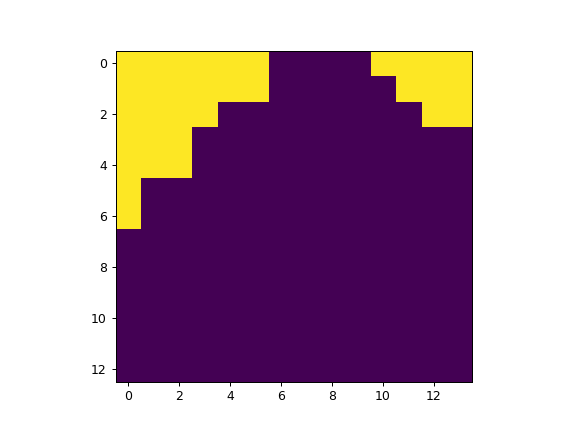

In [12]:
plt.imshow(test02.isel(time=0).temperature)

<IPython.core.display.Javascript object>


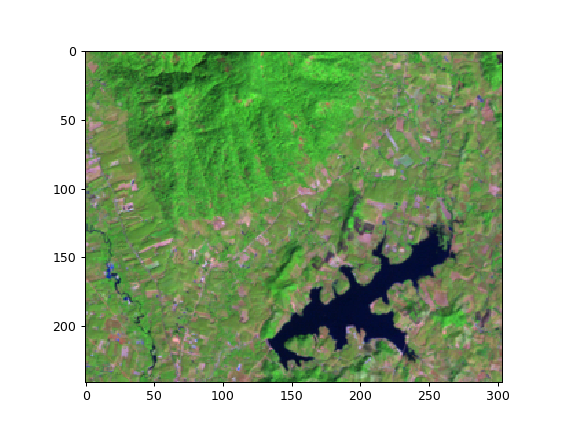

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [146]:
rgb = test02.isel(time=0).to_array(dim='color').sel(color=['swir1',
                                                         'nir', 'green']).transpose('y', 
                                                                                    'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

plt.imshow(scaled)

In [61]:
#Total number of scenes in Cambodia Cube
ls8_datasets = cdc.find_datasets(product='ls8_usgs_sr_scene',**query)
ls7_datasets = cdc.find_datasets(product='ls7_usgs_sr_scene',**query)
ls5_datasets = cdc.find_datasets(product='ls5_usgs_sr_scene',**query)
print(len(ls8_datasets)+len(ls7_datasets)+len(ls5_datasets))
# ls8_datasets[0].metadata_doc

0


In [62]:
# #query number of scenes in certain gm as per year query
# gm_datasets = cdc.find_datasets(product='ls5_usgs_sr_scene',**query)
# len(gm_datasets)

In [2]:
cdc.list_products()
#cdc.list_measurements()

,name,description,lat,format,time,platform,instrument,lon,product_type,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,
6,ls5_usgs_sr_scene,Landsat 5 USGS Collection 1 Level2 Surface Ref...,None,GeoTiff,None,LANDSAT_5,TM,None,LEDAPS,"PROJCS[""WGS 84"",GEOGCS[""WGS 84"",DATUM[""WGS_198...","[-30, 30]",None,"(y, x)"
2,ls7_usgs_sr_scene,Landsat 7 USGS Collection 1 Level2 Surface Ref...,None,GeoTiff,None,LANDSAT_7,ETM,None,LEDAPS,"PROJCS[""WGS 84"",GEOGCS[""WGS 84"",DATUM[""WGS_198...","[-30, 30]",None,"(y, x)"
1,ls8_usgs_sr_scene,Landsat 8 USGS Collection 1 Level2 Surface Ref...,None,GeoTiff,None,LANDSAT_8,OLI_TIRS,None,LaSRC,"PROJCS[""WGS 84"",GEOGCS[""WGS 84"",DATUM[""WGS_198...","[-30, 30]",None,"(y, x)"
5,ls_level2_geomedian_annual,Landsat Level-2 Annual GeoMedian,None,GeoTiff,None,"LANDSAT_5,LANDSAT_7,LANDSAT_8","TM,ETM,OLI_TIRS",None,surface_reflectance_statistical_summary,EPSG:32648,"[-30, 30]","[30720.0, 30720.0]","(y, x)"
7,rainfall_grids_1998_2017,Interpolated Rain Precipitation 3-hour values ...,None,NETCDF,None,rain,rain gauge,None,rainfall,EPSG:4326,"[-0.25, 0.25]",None,"(latitude, longitude)"
8,temperature_grids_1979_2016,Near surface air temperature at 2 m at three h...,None,NETCDF,None,temperature,modelled,None,temperature,EPSG:4326,"[0.5, 0.5]",None,"(latitude, longitude)"


In [7]:
temp_datasets = cdc.find_datasets(product='temperature_grids_1979_2016')#,**query)

In [9]:
len(temp_datasets)

19268

In [67]:
# set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene. 
# Scenes will not be retrieved that have less than the cloud threshold worth of image.
#The default value is "0.90" or >90% image and <10% cloud cover
cloud_free_threshold = 0.20


# lat_min = 13.000 #down
# lat_max = 13.500 #up
# lon_min = 103.000 #left
# lon_max = 103.500 #right  


#define temporal range ()
# start_of_epoch = '2014-01-01'
# end_of_epoch =  '2015-01-01'

# #define first time of interest
# start_of_time01 = '2015-01-01'
# end_of_time01 = '2016-05-01'

# #define second time of interest
# start_of_time02 = '2016-05-02'
# end_of_time02 = '2017-12-31'

# start_of_epoch = '2014-01-01'
# end_of_epoch =  '2014-01-02'

#define wavelengths/bands of interest
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     'pixel_qa',
                     'swir2',
                     ]

#define Landsat sensors of interest
sensors = ['ls5',]
#        'ls7',] 

#query is created
# query = {'time': (start_of_epoch, end_of_epoch),}
# query['x'] = (lon_min, lon_max)
# query['y'] = (lat_max, lat_min)
# query['crs'] = 'EPSG:4326'

print(query)

{'time': ('1994-01-01', '1995-01-01'), 'x': (102.413, 102.54), 'y': (13.414, 13.304), 'crs': 'EPSG:4326'}


In [43]:
# #define temporal range ()
# start_of_epoch = '2014-01-01'
# end_of_epoch =  '2014-02-01'
# query = {'time': (start_of_epoch, end_of_epoch),}

In [62]:
test.y[0]

<xarray.DataArray 'y' ()>
array(1460115.)
Coordinates:
    y        float64 1.46e+06
Attributes:
    units:    metre

In [50]:
test02.isel(time=0).pixel_qa

<xarray.DataArray 'pixel_qa' (y: 744, x: 730)>
array([[66, 66, 66, ..., 72, 72, 72],
       [66, 66, 66, ..., 72, 72, 96],
       [66, 66, 66, ..., 72, 96, 96],
       ...,
       [72, 72, 72, ..., 66, 66, 66],
       [72, 72, 72, ..., 66, 66, 66],
       [72, 72, 72, ..., 66, 66, 66]], dtype=uint16)
Coordinates:
    time     datetime64[ns] 1997-01-04T02:48:58.297000
  * y        (y) float64 1.46e+06 1.46e+06 1.46e+06 1.46e+06 1.46e+06 ...
  * x        (x) float64 2.831e+05 2.831e+05 2.831e+05 2.832e+05 2.832e+05 ...
Attributes:
    nodata:            1
    units:             1
    crs:               PROJCS["WGS 84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    flags_definition:  {'snow': {'bits': 4, 'values': {'0': 'no_snow', '1': '...

<IPython.core.display.Javascript object>


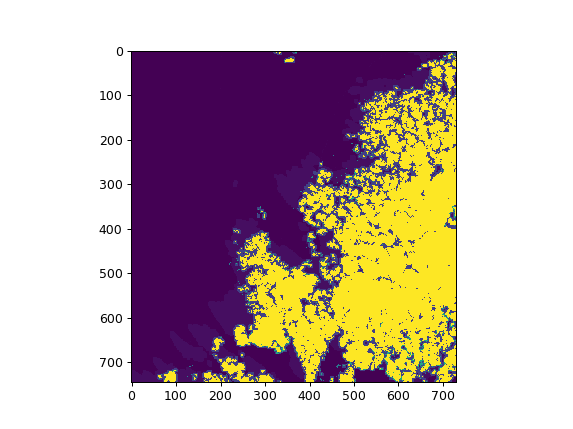

In [54]:
plt.imshow(test02.isel(time=0).pixel_qa)

In [59]:
test= cdc.load(product='ls_level2_geomedian_annual',**query)

In [60]:
test

<xarray.Dataset>
Dimensions:  (time: 1, x: 730, y: 744)
Coordinates:
  * time     (time) datetime64[ns] 1997-01-01
  * y        (y) float64 1.46e+06 1.46e+06 1.46e+06 1.46e+06 1.46e+06 ...
  * x        (x) float64 2.831e+05 2.831e+05 2.831e+05 2.832e+05 2.832e+05 ...
Data variables:
    blue     (time, y, x) int16 830 850 839 849 881 887 830 790 796 794 838 ...
    green    (time, y, x) int16 1125 1147 1149 1160 1189 1201 1153 1120 1100 ...
    red      (time, y, x) int16 1377 1440 1383 1355 1431 1407 1366 1338 1333 ...
    nir      (time, y, x) int16 2456 2520 2559 2527 2522 2509 2472 2482 2493 ...
    swir1    (time, y, x) int16 2987 3150 3107 3014 3088 3119 3026 2943 2969 ...
    swir2    (time, y, x) int16 1867 2055 2008 1944 1972 2020 1885 1819 1807 ...
Attributes:
    crs:      EPSG:32648

In [34]:
test.isel(time=0).to_array(dim='color').sel(color=['swir1','nir', 'green']).transpose('y', 'x', 'color')

<xarray.DataArray (y: 744, x: 730, color: 3)>
array([[[2987, 2456, 1125],
        [3150, 2520, 1147],
        ...,
        [2773, 2813, 1002],
        [2860, 2826, 1149]],

       [[2948, 2434, 1116],
        [2970, 2473, 1100],
        ...,
        [2792, 2745,  954],
        [2810, 2973, 1123]],

       ...,

       [[2777, 2547,  964],
        [2738, 2581,  932],
        ...,
        [3249, 2926, 1320],
        [3311, 2971, 1320]],

       [[2811, 2479,  947],
        [2941, 2526, 1007],
        ...,
        [3280, 2745, 1273],
        [3280, 2745, 1320]]], dtype=int16)
Coordinates:
    time     datetime64[ns] 1997-01-01
  * y        (y) float64 1.46e+06 1.46e+06 1.46e+06 1.46e+06 1.46e+06 ...
  * x        (x) float64 2.831e+05 2.831e+05 2.831e+05 2.832e+05 2.832e+05 ...
  * color    (color) <U5 'swir1' 'nir' 'green'
Attributes:
    crs:      EPSG:32648

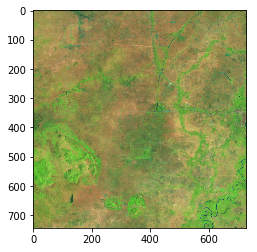

In [36]:
rgb = test.isel(time=0).to_array(dim='color').sel(color=['swir1',
                                                         'nir', 'green']).transpose('y', 
                                                                                    'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

plt.imshow(scaled)

In [63]:
test.rainfall.max()

<xarray.DataArray 'rainfall' ()>
array(15.32)

In [18]:
test.latitude.min()

<xarray.DataArray 'latitude' ()>
array(8.875)

In [ ]:
test= cdc.load(product='ls8_usgs_sr_scene',**query)
# test= test.squeeze()
test

In [ ]:
# three_band_image_subplots(test, ['red','green','blue'], 2, figsize = [30,50])

In [ ]:
# sensor_nbar[0].metadata_doc

In [ ]:
# cdc.load(product='ls7_usgs_sr_scene')

In [ ]:
blah=list(cdc.index.products.search())[1]

In [ ]:
blah.definition

In [89]:
gm_all_datasets = cdc.find_datasets(product='ls_level2_geomedian_annual')
len(gm_all_datasets)

1913

In [91]:
ls7_datasets = cdc.find_datasets(product='ls7_usgs_sr_scene',**query)
len(ls7_datasets)

225

In [ ]:
# list(cdc.index.users.list_users())

In [210]:
#define temporal range ()
start_of_epoch = '1989-01-01'
end_of_epoch =  '1990-01-01'
query = {'time': (start_of_epoch, end_of_epoch),}
print(query)

{'time': ('1989-01-01', '1990-01-01')}


In [102]:
ls8_datasets = cdc.find_datasets(product='ls8_usgs_sr_scene',**query)
ls7_datasets = cdc.find_datasets(product='ls7_usgs_sr_scene',**query)
ls5_datasets = cdc.find_datasets(product='ls5_usgs_sr_scene',**query)
print(len(ls5_datasets)+len(ls7_datasets)+len(ls8_datasets))
# ls8_datasets[0].metadata_doc

0


In [16]:
len(gm_datasets)

1806

In [5]:
# # #Remove all/certain files from database. WARNING.
gm_eager=[d.id for d in gm_datasets]
# print(ls5_eager)
cdc.index.datasets.archive(gm_eager)
gm_datasets = cdc.find_datasets(product='ls_level2_geomedian_annual',**query)

print(len(gm_datasets))

0


In [182]:
# # #Remove all files from database. WARNING.
# ls7_eager=[d.id for d in ls7_datasets]
# cdc.index.datasets.archive(ls7_eager)
# print(len(ls7_datasets))

0


In [183]:
# # #Remove all files from database. WARNING.
# ls5_eager=[d.id for d in ls5_datasets]
# cdc.index.datasets.archive(ls5_eager)
# print(len(ls5_datasets))

0


In [17]:
# # # Remove specific files from database. WARNING.
# gm_eager=[d.id for d in cdc.index.datasets.search_eager(product='ls_level2_geomedian_annual')]#,**query)]
# cdc.index.datasets.archive(gm_eager)

In [121]:
# # Remove specific files from database. WARNING.
# gm_eager=[d.id for d in gm_datasets]#cdc.index.datasets.search_eager(product='ls_level2_geomedian_annual',**query)]
# cdc.index.datasets.archive(gm_eager)

In [122]:
gm_eager

[UUID('252bae22-6f61-4c9e-8b01-08149439051b'),
 UUID('2cdb3492-534f-461b-9088-8a3c13244604'),
 UUID('3c5f1492-95af-4ab5-9c3f-b9d7a510b999'),
 UUID('54d98d86-f1d7-4b13-bc22-d508b818734a'),
 UUID('1827fef7-11e4-4d57-aa65-de5f0e9e0436'),
 UUID('99b5be4c-d74f-4c8a-906b-939700b0b878'),
 UUID('8a07bbfb-55ef-4574-b555-596a5d499664'),
 UUID('e1c138dc-224d-40ec-879b-d1b0c5dbbfa3'),
 UUID('85477d12-c380-469d-901d-8dae714cfa56'),
 UUID('a1e4250a-b6f8-4b0d-8715-aa32ec89ee6d'),
 UUID('e06add73-47ec-4fb4-acea-b97819bb5ac1'),
 UUID('2703af4a-679e-4032-ac01-4b04c07e7386'),
 UUID('25634ce6-d809-4e84-9847-ca4d826ae5a5'),
 UUID('8c083808-b37a-48d1-92dd-0dd282426c43'),
 UUID('d4b1a8a0-f38e-43e5-bc29-4cdffb5d171d'),
 UUID('30e96fa4-2a87-4158-9281-5a387424e992'),
 UUID('089480cd-b0b8-4d41-b27a-cb2fb56f8a30'),
 UUID('ad76e9be-1bd4-439e-9b3a-6d4b41b0829c'),
 UUID('1de6cc99-f094-4289-94f1-31ea277bed1f'),
 UUID('08679a16-b239-4ea9-b637-22ae19037619'),
 UUID('9278691e-c05a-4e9a-b87e-96fc7c61035d'),
 UUID('554a57

In [ ]:
# # Remove all files from database. WARNING.
# ls7_eager=[d.id for d in cdc.index.datasets.search_eager(product='ls7_usgs_sr_scene')]
# cdc.index.datasets.archive(ls7_eager)

In [ ]:
# # Remove all files from database. WARNING.
# ls8_eager=[d.id for d in cdc.index.datasets.search_eager(product='ls8_usgs_sr_scene')]
# cdc.index.datasets.archive(ls8_eager)

In [ ]:
# cdc_ls7= cdc.load(product='ls7_usgs_sr_scene')
# cdc_ls8 = cdc.load(product='ls8_usgs_sr_scene')

In [ ]:
# print(cdc_ls8.time)
# print(cdc_ls7.time)

In [ ]:
# dc = Datacube(app='dc-show changes in annual mean NDVI values')
# dc.list_products()